# Load, explore and process data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("~/Code/pydata_ams/titanic.csv")

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df["Sex"].unique()

array(['male', 'female'], dtype=object)

In [5]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [6]:
df["Pclass"] = df["Pclass"].astype("category")
df["Embarked"] = df["Embarked"].astype("category")

In [7]:
df["Embarked"]

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [8]:
df["Pclass"]

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: category
Categories (3, int64): [1, 2, 3]

In [9]:
X = df[["Embarked", "Pclass", "Sex"]]
y = df["Survived"]

# Train a classification model with `lightgbm`

In [10]:
import lightgbm as lgbm

In [11]:
clf = lgbm.LGBMClassifier(verbosity=-1, max_depth=6)
clf.fit(X, y)

LGBMClassifier(max_depth=6, verbosity=-1)

<Axes: >

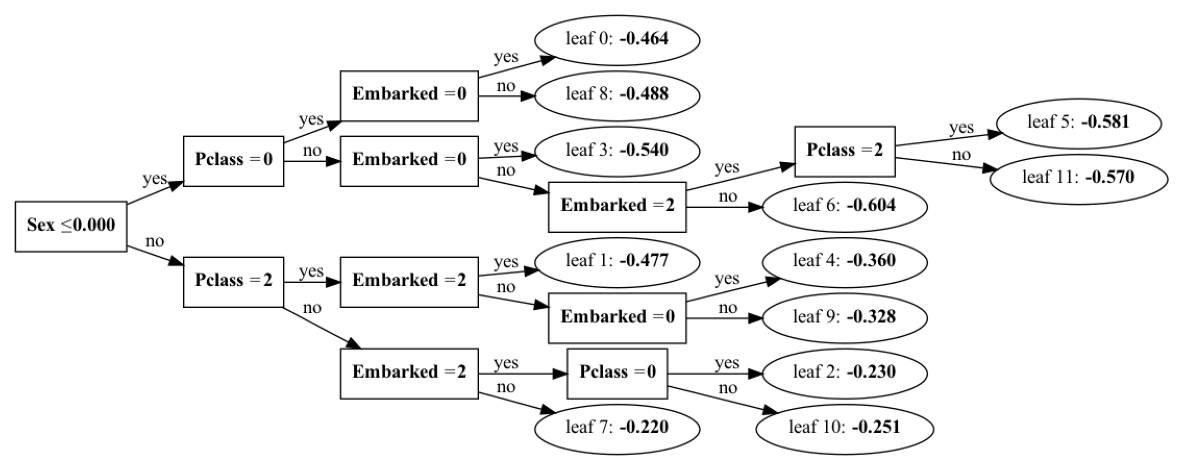

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
lgbm.plot_tree(clf, ax=ax)

# Train a CATE model with `causalml`

In [13]:
import numpy as np
rng = np.random.default_rng()
treatment = pd.Series(rng.binomial(n=1, p=.5, size=len(X)))

In [14]:
treatment

0      0
1      1
2      0
3      1
4      0
      ..
886    1
887    1
888    1
889    0
890    1
Length: 891, dtype: int64

In [15]:
%%capture
from causalml.inference.meta import BaseRClassifier

In [16]:
model = BaseRClassifier(
    outcome_learner=lgbm.LGBMClassifier(verbosity=-1),
    effect_learner=lgbm.LGBMRegressor(verbosity=-1),
    propensity_learner=lgbm.LGBMClassifier(verbosity=-1),
)

In [17]:
model.fit(X=X, treatment=treatment, y=y)

ValueError: could not convert string to float: 'S'

In [18]:
X_reduced = X[["Pclass", "Sex"]]
model.fit(X=X_reduced, treatment=treatment, y=y)

<Axes: >

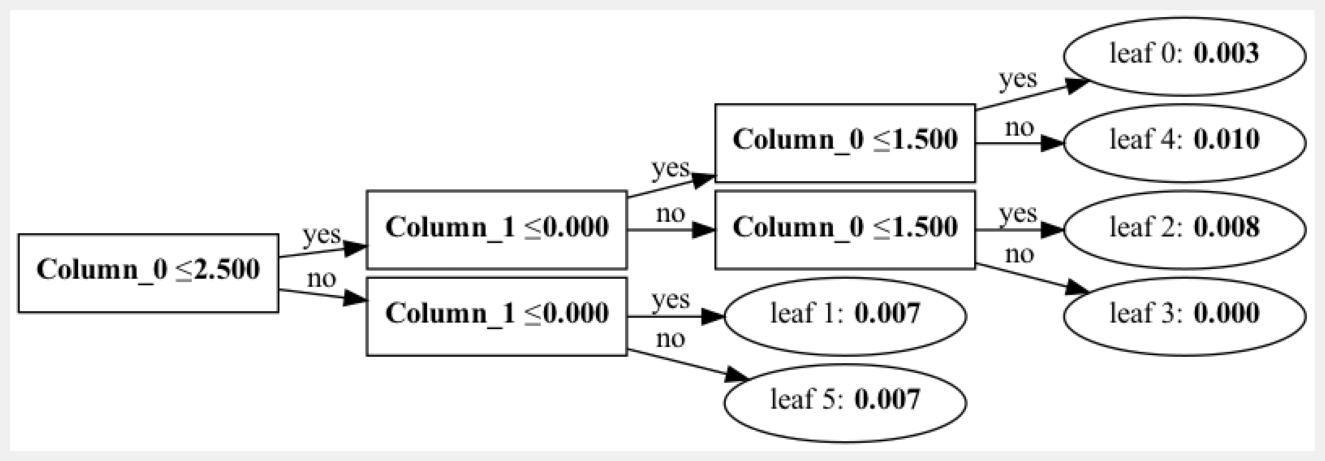

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
lgbm.plot_tree(model.models_tau[1], ax=ax)

# Train a CATE model with `econml`

In [23]:
from econml.dml import 

In [30]:
est = DRLearner(
    model_propensity=lgbm.LGBMClassifier(verbosity=-1),
    model_regression=lgbm.LGBMRegressor(verbosity=-1),
    model_final=lgbm.LGBMRegressor(verbosity=-1),
)
est.fit(y, treatment, X=X_reduced)

Not all column names are strings. Coercing to strings for now.


<Axes: >

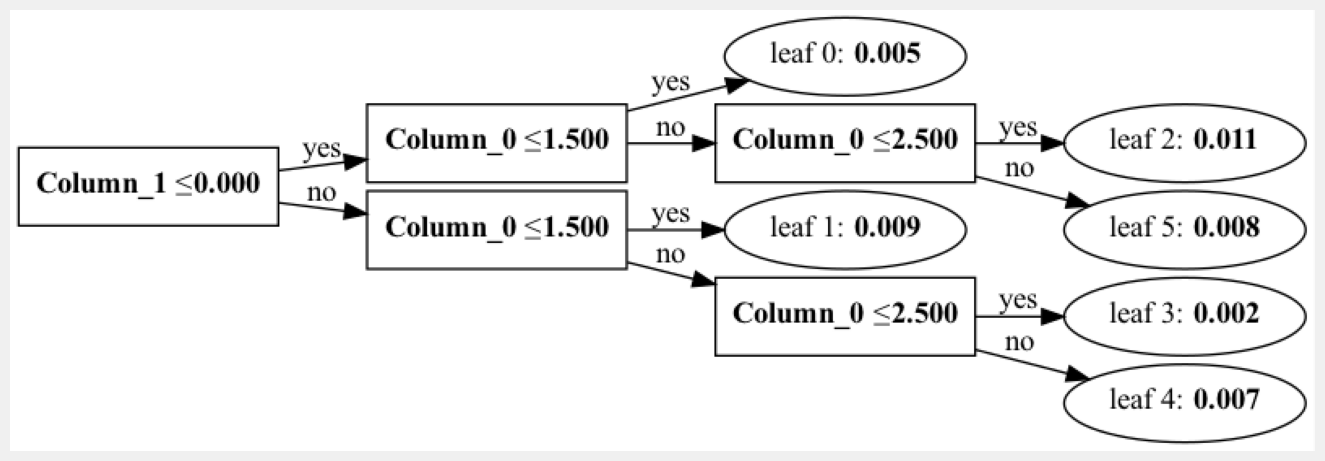

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
lgbm.plot_tree(est._ortho_learner_model_final.models_cate[0], ax=ax)